# Introduction

https://www.pricederivatives.com/en/derivatives-cva-example-monte-carlo-python/

Here we’ll show an example of code for CVA calculation (credit valuation adjustment) using python and Quantlib with simple Monte-Carlo method with portfolio consisting just of a single interest rate swap.It’s easy to generalize code to include more financial instruments , supported by QuantLib python Swig interface.

**CVA calculation algorithm**
1) Simulate yield curve at future dates

2) Calculate your derivatives portfolio NPV (net present value) at each time point for each scenario

3) Calculate CVA as sum of Expected Exposure multiplied by probability of default at this interval

$$CVA=(1−R)\int DF(t)EE(t)dQt$$
where R is Recovery (normally set to 40%) EE(t) expected exposure at time $t$ and $dQ$ survival probability density , $DF(t)$ discount factor at time $t$

**Outline**
1) In this simple example we will use Hull White model to generate future yield curves. In practice many banks use some yield curve evolution models based on historical simulations.
In Hull White model short rate $r_t$ is distributed normally with known mean and variance.

2) For each point of time we will generate whole yield curve based on short rate. Then we will price our interest rate swap on each of these curves.

3) To approximate CVA we will use BASEL III formula for regulatory capital charge approximating default probability [or survival probability ] as $\exp(-S_T/(1-R))$
so we get
$$CVA=(1−R)\sum\frac{EE^∗_{T_i}+EE^∗_{T_{i−1}} }{2}\left(e^{−\frac{ ST_{i−1}}{1−R} }−e^{−\frac{ST_i}{1−R} }\right)^+$$

where $EE^*$ is discounted Expected exposure of portfolio

**Details** 

For this first example we’ll take 5% flat forward yield curve. In the second test example below we’ll take full curve as of 26/12/2013.

1) Hull-White model for future yield curve simulations

the model is given by dynamics:
$$dr_t=(\theta_t−ar_t)dt+\sigma dW_t$$

By chosing  $$\theta_t = f_t(0, t) + af(0, t) + \frac{\sigma^2}{2a}(1-e^{-2at})$$,

We will use that in Hull White model short rate $r_t$ is distributed normally with mean and variance given by
$$E(r_t|r_s)=r_se^{−a(t−s)}+\gamma_t−\gamma_se^{−a(t−s)}$$
and 
$$Var(r_t|r_s)=\frac{\sigma^2}{2a}\left(1−e^{−2a(t−s)}\right)$$

where
$$\gamma_t=f_t(0)+\frac{\sigma^2}{2a^2}\left(1−e^{−at}\right)^2$$

and $f_t(0)$ is instantaneous forward rate at time $t$ as seen at time 0, as shown in Brigo & Mercurio's book on Interest Rate Models.

To generate future values of $r_t$,  first we will generate matrix of standard normal variables using numpy library function numpy.random.standard_normal(). After that we will apply transform
$$mean+\sqrt{variance}*Normal(0,1)$$
to get $r_t$

after getting matrix of all $r_t$

for all simulations and time points we will construct yield curve for each $r_t$

using Hull White discount factors
$$P_{->T}(t)=A(t,T)e^{−B(t,T)r_t}$$
for 20 years and store each yield curve in matrix crvMat

2) Valuing portfolio
On each of this curve we will value swap using QuantLib function. you can add more financial instruments just by adding its value to global NPV

For our example portfolio we’ll take one interest rate swap EUR 10MM notional receiving 5% every 6m , TARGET calendar, with 5 years maturity.
Actual/360 daycounter for both legs.

3) CVA calculation
After getting matrix of all NPV at each point for each simulation we will replace negative values with 0.
Then we average each column of the matrix (corresponding to averaging for each time point) to get Expected Exposure.
and finally calculate CVA as sum as in BASEL 3 formula.
here we’ll take 500bps flat CDS spread.

# CVA calculation
First, install QuantLib package for python, to run the program just copy paste it into iPython editor and press enter

In [18]:
crvToday.forwardRate(0.7,0.7, Continuous, NoFrequency).rate()
Period(2,Years)
len(T)

60


CVA= 17008.590268933684

EE
 [[143606.52236152 110892.25913033 123290.20415129 ...  13967.58057333
   13977.69516598  14005.16151835]
 [143606.52236152 126227.03001656 141763.93414938 ...  13899.14723321
   13944.45211361  14001.20809908]
 [143606.52236152 121295.88270064 113094.03325023 ...  13806.22098036
   13884.49671652  13951.8993805 ]
 ...
 [143606.52236152 122839.24885826 100364.02025741 ...  13945.0936529
   13977.09778729  14012.67541012]
 [143606.52236152 132998.08151752 166252.5282214  ...  14097.25299989
   14095.04320873  14067.92423857]
 [143606.52236152 177737.59151528 194720.39115905 ...  14071.24723422
   14064.61259999  14040.44191233]]


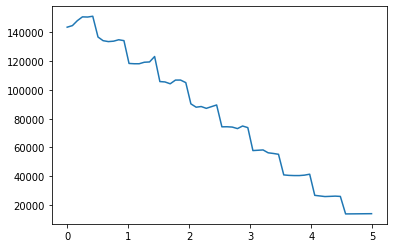

In [4]:
#(c) 2013 PriceDerivatives.com
# Distributed without any warranty.For educational purposes only.

from  QuantLib import *
import numpy as np
from math import *
from pylab import *

def A(t,T):
    forward = crvToday.forwardRate(t, t,Continuous, NoFrequency).rate()
    value = B(t,T)*forward - 0.25*sigma*B(t,T)*sigma*B(t,T)*B(0.0,2.0*t);
    return exp(value)*crvToday.discount(T)/crvToday.discount(t);

def B(t,T):
    return (1.0-exp(-a*(T-t)))/a;

def gamma(t):
        forwardRate =crvToday.forwardRate(t, t, Continuous, NoFrequency).rate()
        temp = sigma*(1.0 - exp(-a*t))/a
        return (forwardRate + 0.5*temp*temp)

def gamma_v(t):
    res=np.zeros(len(t))
    for i in range(len(t)):
        res[i]=gamma(t[i])
    return res

Nsim=100
a=0.1
sigma=0.02

todaysDate=Date(30,12,2013);
Settings.instance().evaluationDate=todaysDate;
crvToday=FlatForward(todaysDate,0.02,Actual360())

r0=forwardRate =crvToday.forwardRate(0,0, Continuous, NoFrequency).rate()
months=range(1,12*5,1)
sPeriods=[str(month)+"m" for month in months]
Dates=[todaysDate]+[todaysDate+Period(s) for s in sPeriods]
T=[0]+[Actual360().yearFraction(todaysDate,Dates[i]) for i in range(1,len(Dates))]
T=np.array(T)
rmean=r0*np.exp(-a*T)+ gamma_v(T) -gamma(0)*np.exp(-a*T)

np.random.seed(1)
stdnorm = np.random.standard_normal(size=(Nsim,len(T)-1))

rmat=np.zeros(shape=(Nsim,len(T)))
rmat[:,0]=r0

for iSim in range(Nsim):
    for iT in range(1,len(T)):
        mean=rmat[iSim,iT-1]*exp(-a*(T[iT]-T[iT-1]))+gamma(T[iT])-gamma(T[iT-1])*exp(-a*(T[iT]-T[iT-1]))
        var=0.5*sigma*sigma/a*(1-exp(-2*a*(T[iT]-T[iT-1])))
        rmat[iSim,iT]=mean+stdnorm[iSim,iT-1]*sqrt(var)

startDate=Date(30,12,2013);

crvMat= [ [ 0 for i in range(len(T)) ] for iSim in range(Nsim) ]
npvMat= [ [ 0 for i in range(len(T)) ] for iSim in range(Nsim) ]

for row in crvMat:
    row[0]=crvToday

for iT in range(1,len(T)):
    for iSim in range(Nsim):
        crvDate=Dates[iT];
        crvDates=[crvDate]+[crvDate+Period(k,Years) for k in range(1,21)]
        crvDiscounts=[1.0]+[A(T[iT],T[iT]+k)*exp(-B(T[iT],T[iT]+k)*rmat[iSim,iT]) for k in range(1,21)]
        crvMat[iSim][iT]=DiscountCurve(crvDates,crvDiscounts,Actual360(),TARGET())

#indexes definitions
forecastTermStructure = RelinkableYieldTermStructureHandle()
index = Euribor(Period("6m"),forecastTermStructure)

#swap 1 definition
maturity = Date(30,12,2018);
fixedSchedule = Schedule(startDate, maturity,Period("6m"), TARGET(),ModifiedFollowing,ModifiedFollowing,DateGeneration.Forward, False)
floatingSchedule = Schedule(startDate, maturity,Period("6m"),TARGET() ,ModifiedFollowing,ModifiedFollowing,DateGeneration.Forward, False)
swap1 = VanillaSwap(VanillaSwap.Receiver, 1000000,fixedSchedule,0.05 , Actual360(),floatingSchedule, index, 0,Actual360())  #0.01215

for iT in range(len(T)):
    Settings.instance().evaluationDate=Dates[iT]
    allDates= list(floatingSchedule)
    fixingdates=[index.fixingDate(floatingSchedule[iDate]) for iDate in range(len(allDates)) if index.fixingDate(floatingSchedule[iDate])<=Dates[iT]]
    if fixingdates:
        for date in fixingdates[:-1]:
            try:index.addFixing(date,0.0)
            except:pass
        try:index.addFixing(fixingdates[-1],rmean[iT])
        except:pass
    discountTermStructure = RelinkableYieldTermStructureHandle()
    swapEngine = DiscountingSwapEngine(discountTermStructure)
    swap1.setPricingEngine(swapEngine)

    for iSim in range(Nsim):
        crv=crvMat[iSim][iT]
        discountTermStructure.linkTo(crv)
        forecastTermStructure.linkTo(crv)
        npvMat[iSim][iT]=swap1.NPV()

npvMat=np.array(npvMat)
npvMat[npvMat<0]=0
EE=np.mean(npvMat,axis=0)

S=0.05 #constant CDS spread
R=0.4  #Recovery rate 40%

sum=0
#calculate CVA
for i in range(len(T)-1):
    sum=sum+0.5*(EE[i]*crvToday.discount(T[i])+EE[i+1]*crvToday.discount(T[i+1]))*(exp(-S*T[i]/(1.0-R))-exp(-S*T[i+1]/(1.0-R)))
CVA=(1.0-R)*sum

print("\nCVA=",CVA)

plot(T,EE)
print( "\nEE\n",npvMat )
show()